In [1]:
import cv2
import numpy as np
import os
from pathlib import Path
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind



import Analysis_utils as au

In [2]:
# Define the working directory and paths
working_dir = Path(os.getcwd())
segmentation_dir = os.path.join(working_dir, 'segmentation_outputs')

Attention: if not performed segmentation on this folder you will not have the folder named 'segmentation_outputs', if you don't want to perform the segmentation for computational time reasons or others you can dowload the folder from the [Google drive](https://drive.google.com/drive/folders/15EFxsOXxLsh5dPxTruXf7JRL8ahgMC0D?usp=drive_link). Place the folder togheter with the 'Part_C.ipynb' notebook and the 'Analysis_utils.py' file and run all the cells in the order. Once you have the csv data you can skip the code for creating them (also these are present on the drive and can be downloaded).

# Extract features from the segmentations outputs and create csv

In [3]:
# Iterate over each folder in the segmentation_outputs directory
for folder in os.listdir(segmentation_dir):
    folder_path = os.path.join(segmentation_dir, folder)
    txt_dir = os.path.join(folder_path, 'txt_outlines')
    img_dir = os.path.join(folder_path, 'outlines')
    csv_path = os.path.join(segmentation_dir, f"{folder}_data.csv")
    filtered_contour_csv_path = os.path.join(segmentation_dir, f"{folder}_data_filtered_contour.csv")

    data_list = []
    filtered_data_list = []

    if os.path.isdir(txt_dir):
        # Process each .txt file in the txt_outlines directory
        for txt_file in sorted(os.listdir(txt_dir)):
            if txt_file.endswith('.txt'):
                txt_file_path = os.path.join(txt_dir, txt_file)
                frame_number = int(txt_file.split('_')[1])  # Corrected frame number extraction
                
                # Load the corresponding image for the current contour file
                img_file = f"frame_{frame_number:04d}_outlines.png"
                img_file_path = os.path.join(img_dir, img_file)
                image = cv2.imread(img_file_path, cv2.IMREAD_GRAYSCALE)

                if image is None:
                    print(f"Failed to load image: {img_file_path}")
                    continue

                contours = au.get_contours_from_file(txt_file_path)

                # Process each contour and calculate features
                for contour in contours:

                    area, perimeter, circularity, deformation, solidity, mean_intensity = au.calculate_features(image, contour)

                    data_list.append({
                        'Frame': frame_number,
                        'Area': area,
                        'Perimeter': perimeter,
                        'Circularity': circularity,
                        'Deformation': deformation,
                        'Solidity': solidity,
                        'MeanIntensity': mean_intensity
                    })
                    
                    # Check if the contour is touching the edge of the image
                    if not au.is_contour_touching_edge(contour, image.shape[:2]):
                        filtered_data_list.append({
                            'Frame': frame_number,
                            'Area': area,
                            'Perimeter': perimeter,
                            'Circularity': circularity,
                            'Deformation': deformation,
                            'Solidity': solidity,
                            'MeanIntensity': mean_intensity
                        })

        # Write all data to cvs
        with open(csv_path, 'w', newline='') as csv_file:
            fieldnames = ['Frame', 'Area', 'Perimeter', 'Circularity', 'Deformation', 'Solidity', 'MeanIntensity']
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(data_list)
        print(f"Data from {folder} has been saved to {segmentation_dir}")
        
        df = pd.read_csv(csv_path)
        # Get the number of rows and columns
        num_rows, num_columns = df.shape
        print(f"The CSV file '{csv_path}' contains {num_rows} rows and {num_columns} columns.")

        with open(filtered_contour_csv_path, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(filtered_data_list)
        print(f"Filtered data from {folder} has been saved to {segmentation_dir}")
        
        df = pd.read_csv(filtered_contour_csv_path)
        # Get the number of rows and columns
        num_rows, num_columns = df.shape
        print(f"The CSV file '{filtered_contour_csv_path}' contains {num_rows} rows and {num_columns} columns.")

Data from CellA_GFP has been saved to C:\Users\Giona\ME-480\Progetto 2\segmentation_outputs
The CSV file 'C:\Users\Giona\ME-480\Progetto 2\segmentation_outputs\CellA_GFP_data.csv' contains 18444 rows and 7 columns.
Filtered data from CellA_GFP has been saved to C:\Users\Giona\ME-480\Progetto 2\segmentation_outputs
The CSV file 'C:\Users\Giona\ME-480\Progetto 2\segmentation_outputs\CellA_GFP_data_filtered_contour.csv' contains 13786 rows and 7 columns.
Data from CellA_ShME480 has been saved to C:\Users\Giona\ME-480\Progetto 2\segmentation_outputs
The CSV file 'C:\Users\Giona\ME-480\Progetto 2\segmentation_outputs\CellA_ShME480_data.csv' contains 4748 rows and 7 columns.
Filtered data from CellA_ShME480 has been saved to C:\Users\Giona\ME-480\Progetto 2\segmentation_outputs
The CSV file 'C:\Users\Giona\ME-480\Progetto 2\segmentation_outputs\CellA_ShME480_data_filtered_contour.csv' contains 3721 rows and 7 columns.
Data from CellB_GFP has been saved to C:\Users\Giona\ME-480\Progetto 2\seg

# Plot all data

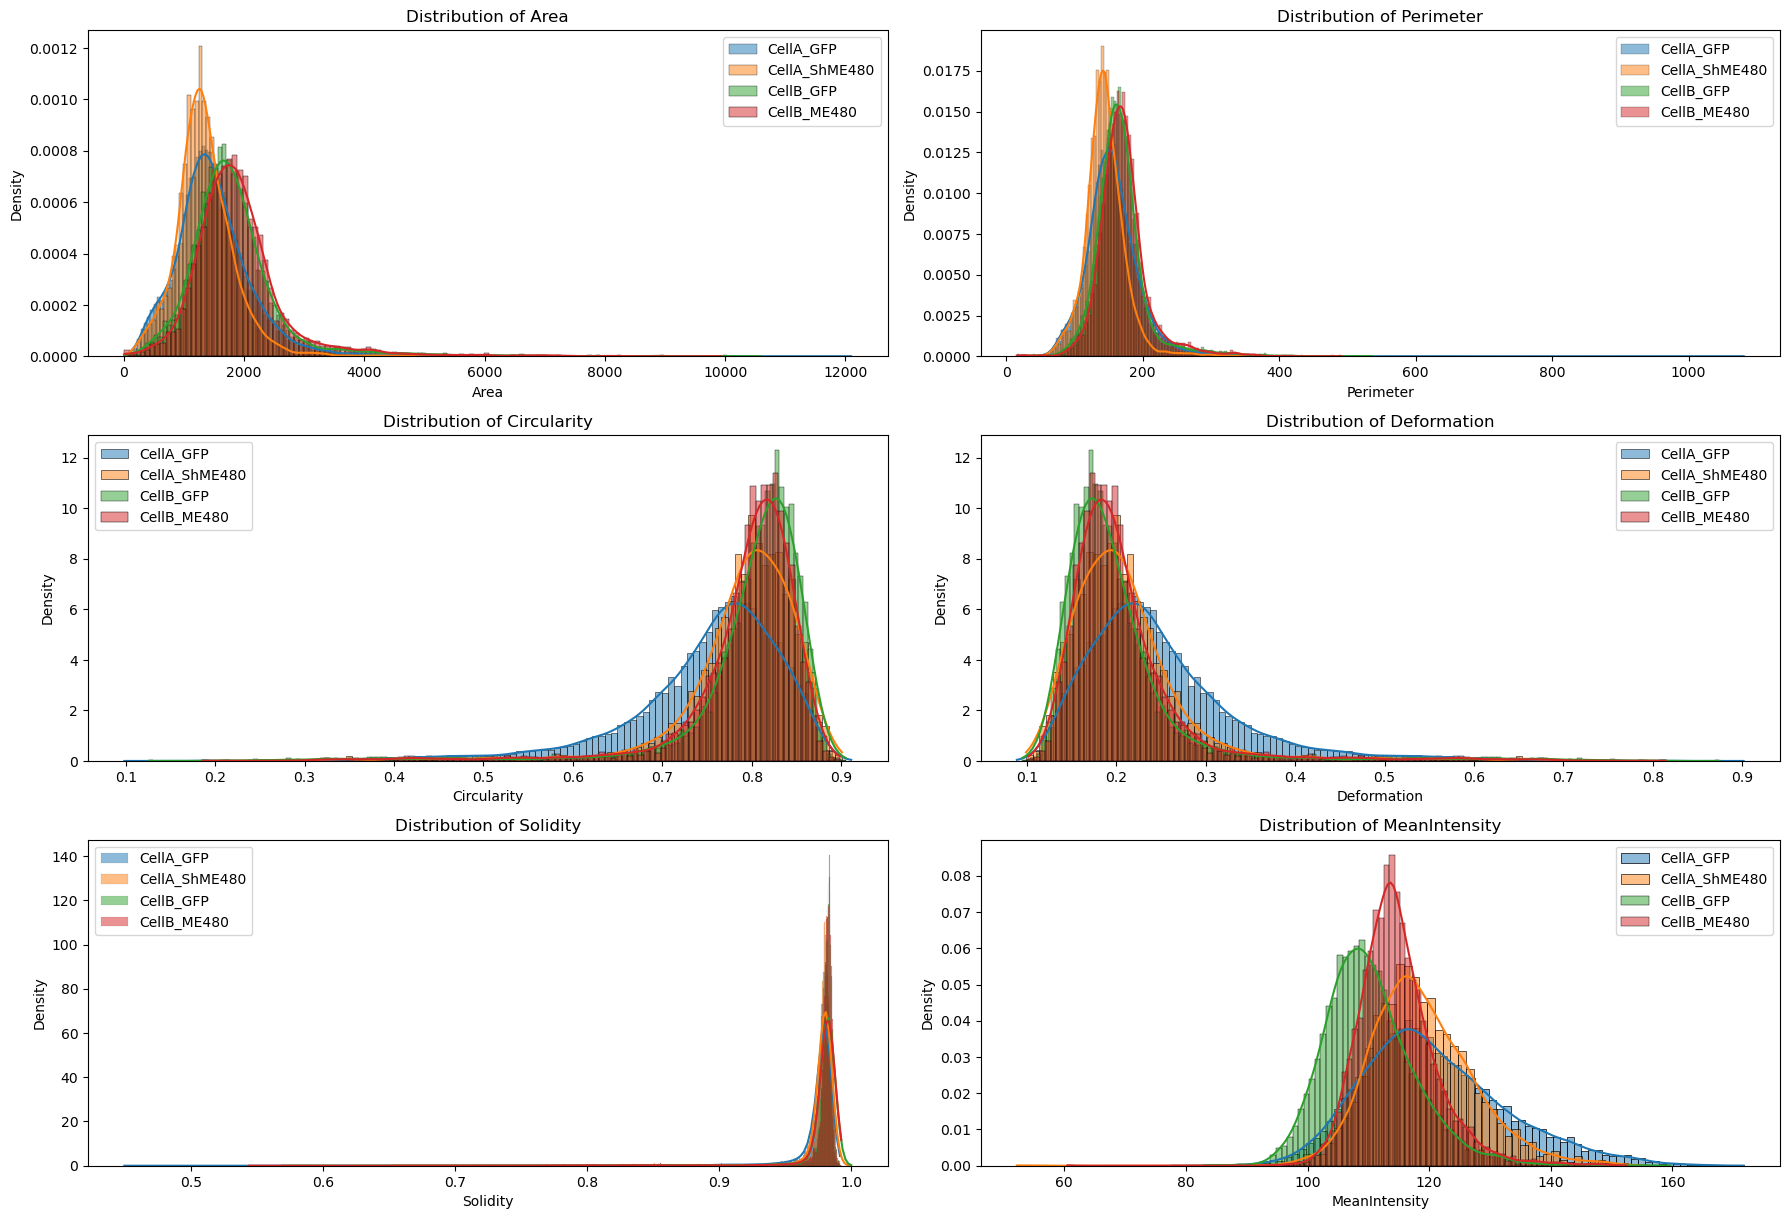

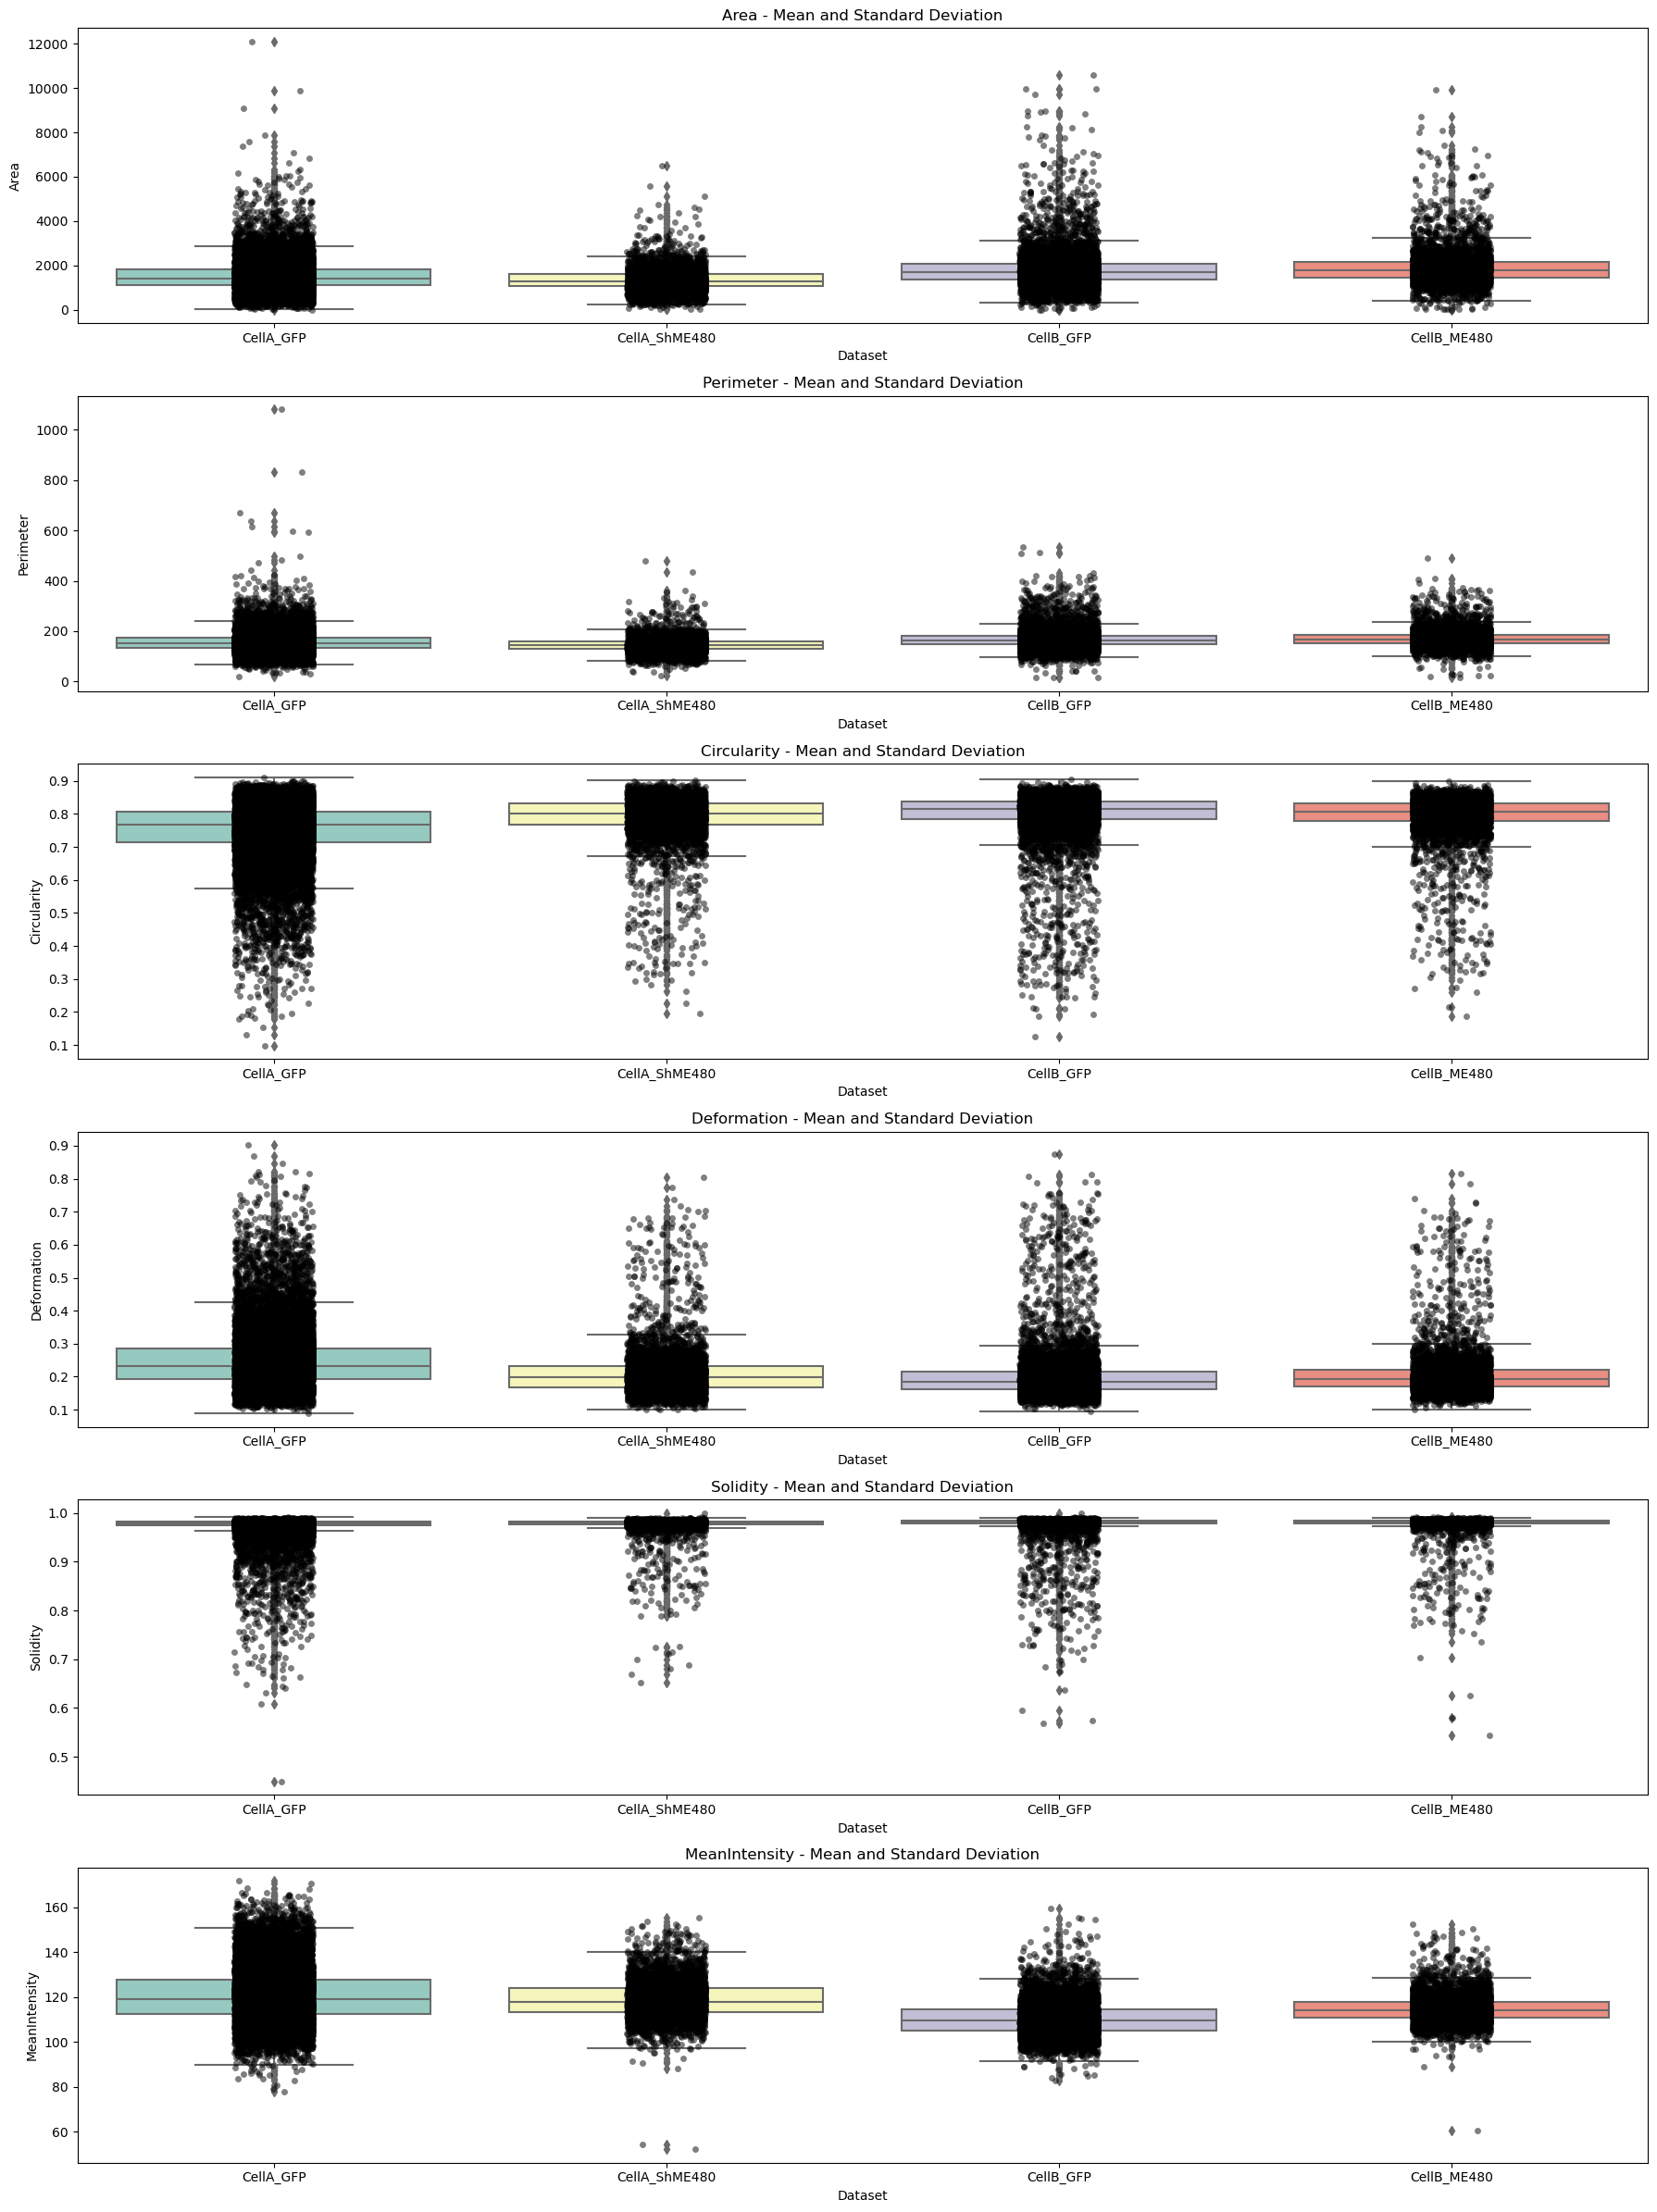

In [4]:
data_frames = []

for file in os.listdir(segmentation_dir):
    if file.endswith('_data.csv'):
        df = pd.read_csv(os.path.join(segmentation_dir, file))
        df['Dataset'] = file.replace('_data.csv', '')
        data_frames.append(df)

all_data = pd.concat(data_frames)

# Variables to plot
plot_variables = ['Area', 'Perimeter', 'Circularity', 'Deformation', 'Solidity', 'MeanIntensity']

num_rows = len(plot_variables)
# Plotting distributions for each variable
plt.figure(figsize=(18, num_rows * 4))
for i, variable in enumerate(plot_variables):
    au.plot_distribution(all_data, variable, i+1, num_rows, 2)

plt.tight_layout()
plt.show()

# Plotting box plots with scatter overlay for each variable
plt.figure(figsize=(18, num_rows * 4))  # Adjust the figure size based on the number of variables
for i, variable in enumerate(plot_variables):
    au.plot_boxplot_with_scatter(all_data, variable, i+1, num_rows)

plt.tight_layout()
plt.show()

# Plot all data with filtered contour

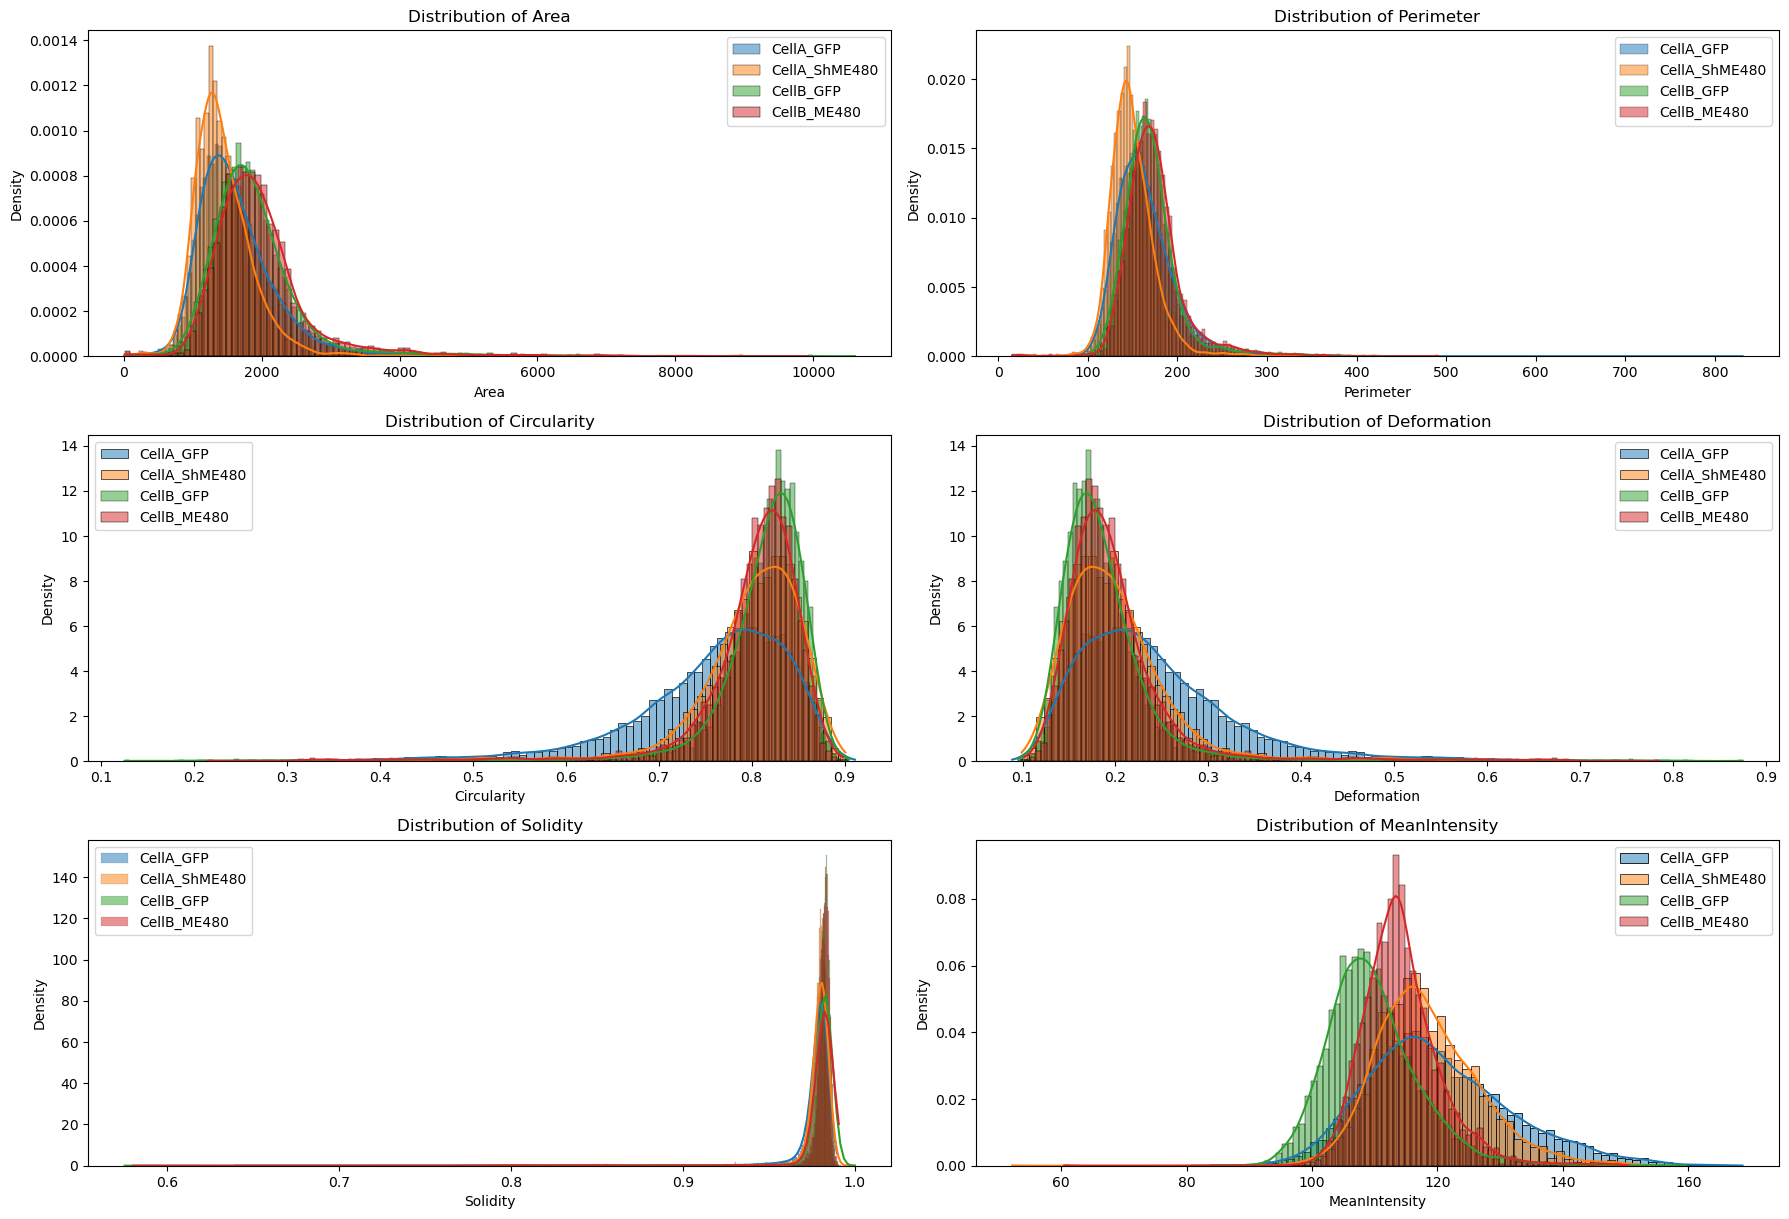

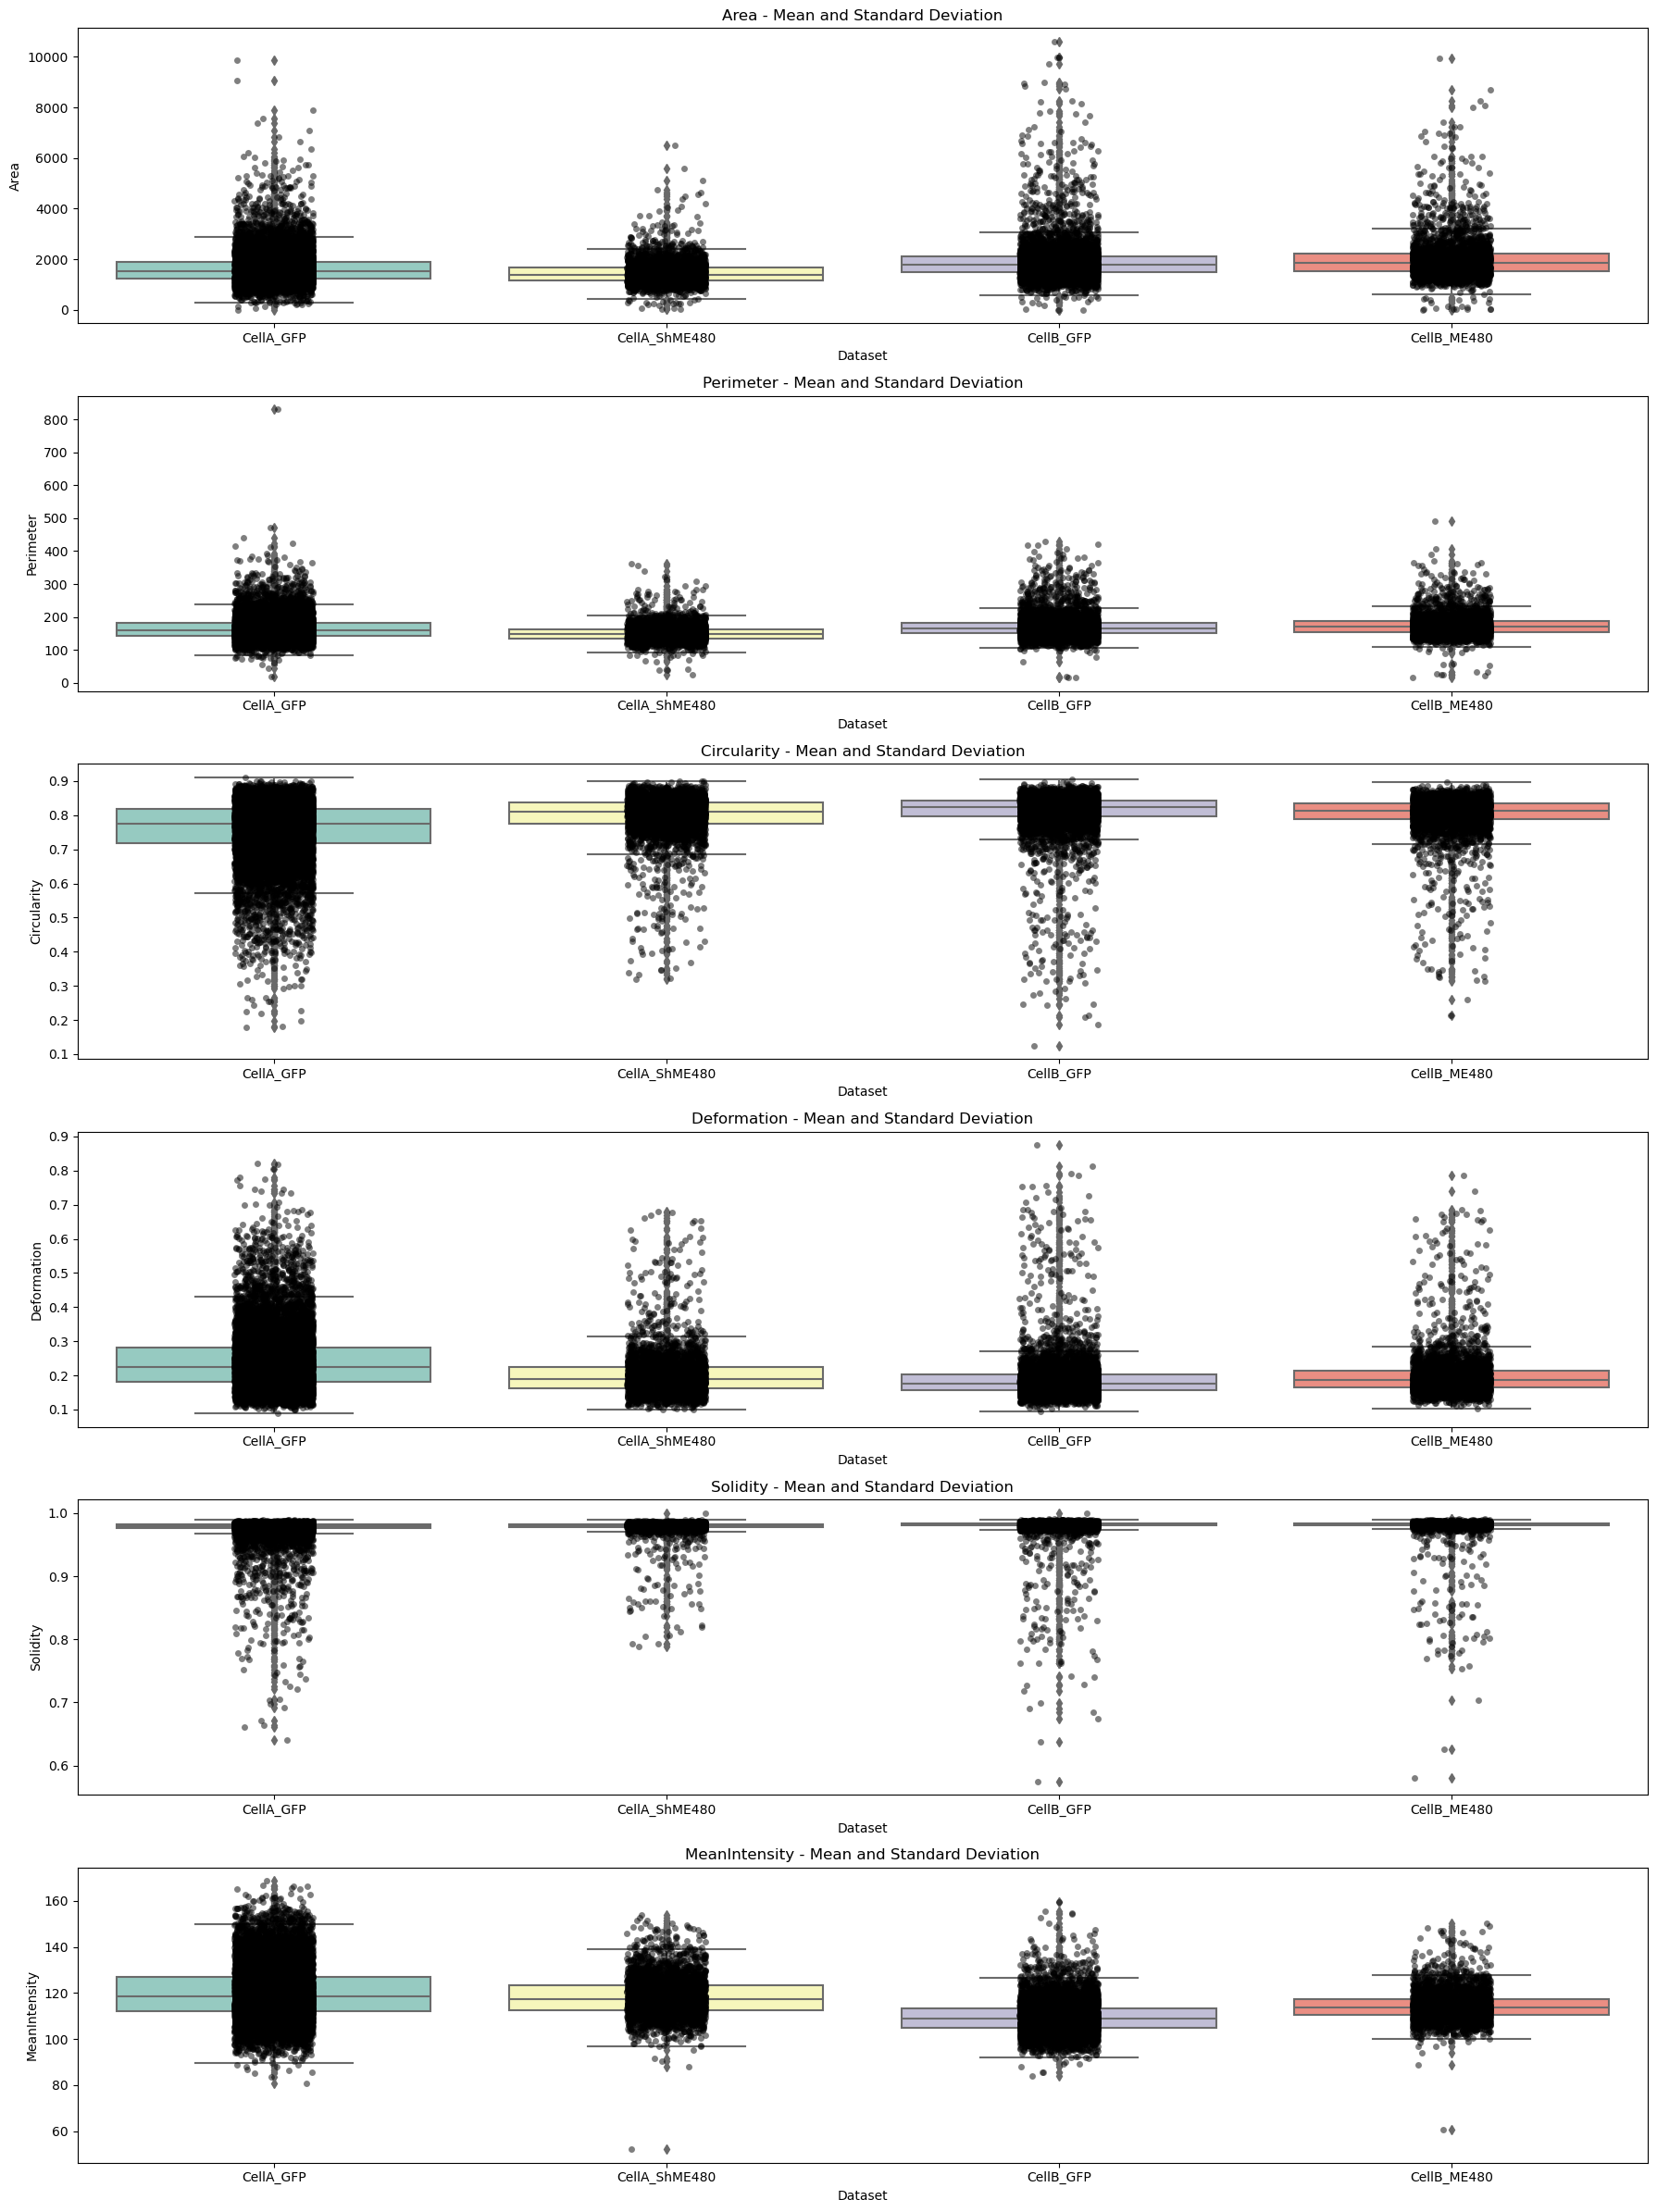

In [5]:
data_frames = []

for file in os.listdir(segmentation_dir):
    if file.endswith('_data_filtered_contour.csv'):
        df = pd.read_csv(os.path.join(segmentation_dir, file))
        df['Dataset'] = file.replace('_data_filtered_contour.csv', '')
        data_frames.append(df)

all_data = pd.concat(data_frames)

# Variables to plot
plot_variables = ['Area', 'Perimeter', 'Circularity', 'Deformation', 'Solidity', 'MeanIntensity']

num_rows = len(plot_variables)
# Plotting distributions for each variable
plt.figure(figsize=(18, num_rows * 4))
for i, variable in enumerate(plot_variables):
    au.plot_distribution(all_data, variable, i+1, num_rows, 2)

plt.tight_layout()
plt.show()

# Plotting box plots with scatter overlay for each variable
plt.figure(figsize=(18, num_rows * 4))  # Adjust the figure size based on the number of variables
for i, variable in enumerate(plot_variables):
    au.plot_boxplot_with_scatter(all_data, variable, i+1, num_rows)

plt.tight_layout()
plt.show()

# Create new csv without wrong contours and without outliers data in 'Solidity' and 'MeanIntensity'

In [6]:
datasets = ['CellA_GFP', 'CellA_ShME480', 'CellB_GFP', 'CellB_ME480']

# Features to analyze
selected_features = ['Solidity', 'MeanIntensity']

for dataset_name in datasets:
    dataset_data = pd.read_csv(os.path.join(segmentation_dir, f'{dataset_name}_data_filtered_contour.csv'))
    # Remove outliers for selected features
    filtered_data = au.remove_selected_outliers(dataset_data, selected_features)
    filtered_data_csv_path = os.path.join(segmentation_dir, f'{dataset_name}_data_filtered_contour_and_outliers.csv')    
    # Save the filtered data to a CSV file
    filtered_data.to_csv(filtered_data_csv_path, index=False)
    print(f"Outlier filtered data from {dataset_name} has been saved to {segmentation_dir}")
    

    
    df = pd.read_csv(filtered_data_csv_path)
    num_rows, num_columns = df.shape
    print(f"The CSV file '{filtered_data_csv_path}' contains {num_rows} rows and {num_columns} columns.")

Outlier filtered data from CellA_GFP has been saved to C:\Users\Giona\ME-480\Progetto 2\segmentation_outputs
The CSV file 'C:\Users\Giona\ME-480\Progetto 2\segmentation_outputs\CellA_GFP_data_filtered_contour_and_outliers.csv' contains 12595 rows and 7 columns.
Outlier filtered data from CellA_ShME480 has been saved to C:\Users\Giona\ME-480\Progetto 2\segmentation_outputs
The CSV file 'C:\Users\Giona\ME-480\Progetto 2\segmentation_outputs\CellA_ShME480_data_filtered_contour_and_outliers.csv' contains 3456 rows and 7 columns.
Outlier filtered data from CellB_GFP has been saved to C:\Users\Giona\ME-480\Progetto 2\segmentation_outputs
The CSV file 'C:\Users\Giona\ME-480\Progetto 2\segmentation_outputs\CellB_GFP_data_filtered_contour_and_outliers.csv' contains 5921 rows and 7 columns.
Outlier filtered data from CellB_ME480 has been saved to C:\Users\Giona\ME-480\Progetto 2\segmentation_outputs
The CSV file 'C:\Users\Giona\ME-480\Progetto 2\segmentation_outputs\CellB_ME480_data_filtered_con

# Plot all quantities against each other

In [ ]:
cella_gfp_data = pd.read_csv('segmentation_outputs/CellA_GFP_data_filtered_contour_and_outliers.csv')
cella_shme480_data = pd.read_csv('segmentation_outputs/CellA_ShME480_data_filtered_contour_and_outliers.csv')
cellb_gfp_data = pd.read_csv('segmentation_outputs/CellB_GFP_data_filtered_contour_and_outliers.csv')
cellb_me480_data = pd.read_csv('segmentation_outputs/CellB_ME480_data_filtered_contour_and_outliers.csv')


# Combine datasets for comparison
data = {
    'CellA GFP': cella_gfp_data,
    'CellA ShME480': cella_shme480_data,
    'CellB GFP': cellb_gfp_data,
    'CellB ME480': cellb_me480_data
}

# Define the metrics for comparison
metrics = ['Area', 'Perimeter', 'Circularity', 'Deformation', 'Solidity', 'MeanIntensity']

# Call the function to plot the scatter matrix
au.plot_scatter_matrix(data, metrics)


# Call the function to plot the scatter matrix with central points
au.plot_scatter_matrix_mean(data, metrics)


# Plot filtered data per cell type A/B

In [ ]:
data_frames = []

cella_gfp_data = pd.read_csv('segmentation_outputs/CellA_GFP_data_filtered_contour_and_outliers.csv')
cella_shme480_data = pd.read_csv('segmentation_outputs/CellA_ShME480_data_filtered_contour_and_outliers.csv')
cellb_gfp_data = pd.read_csv('segmentation_outputs/CellB_GFP_data_filtered_contour_and_outliers.csv')
cellb_me480_data = pd.read_csv('segmentation_outputs/CellB_ME480_data_filtered_contour_and_outliers.csv')

cella_gfp_data['Dataset'] = 'CellA_GFP'
cella_shme480_data['Dataset'] = 'CellA_ShME480'
cellb_gfp_data['Dataset'] = 'CellB_GFP'
cellb_me480_data['Dataset'] = 'CellB_ME480'

# Combine data by cell type
cella_data = pd.concat([cella_gfp_data, cella_shme480_data])
cellb_data = pd.concat([cellb_gfp_data, cellb_me480_data])

# Variables to plot
plot_variables = ['Area', 'Perimeter', 'Circularity', 'Deformation', 'Solidity', 'MeanIntensity']

for i, variable in enumerate(plot_variables):
    # Create a new figure for each plot
    plt.figure(figsize=(18, 4))

    # Plot the data
    au.plot_distribution_side_by_side(cella_data, cellb_data, variable, 
                                      f'Cell A - Distribution of {variable}', 
                                      f'Cell B - Distribution of {variable}', 
                                      1, 2, 1)  # Adjust num_rows and subplot_index accordingly

    # Save the current figure
    #plt.savefig(f'{variable}_distr.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    # Close the figure to free up memory
    plt.close()


for i, variable in enumerate(plot_variables):
    # Create a new figure for each plot
    plt.figure(figsize=(18, 4))

    # Plot the data
    au.plot_boxplots_side_by_side(cella_data, cellb_data, variable,
                                  f'Cell A - {variable}',
                                  f'Cell B - {variable}',
                                  1, 2, 1)  # Note: num_rows and subplot_index are adjusted

    # Save the current figure
    #plt.savefig(f'{variable}_box.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    # Close the figure to free up memory
    plt.close()


# Plot filtered data grouped by ME480 expression

In [ ]:
data_frames = []

cella_gfp_data = pd.read_csv('segmentation_outputs/CellA_GFP_data_filtered_contour_and_outliers.csv')
cella_shme480_data = pd.read_csv('segmentation_outputs/CellA_ShME480_data_filtered_contour_and_outliers.csv')
cellb_gfp_data = pd.read_csv('segmentation_outputs/CellB_GFP_data_filtered_contour_and_outliers.csv')
cellb_me480_data = pd.read_csv('segmentation_outputs/CellB_ME480_data_filtered_contour_and_outliers.csv')

cella_gfp_data['Dataset'] = 'CellA_GFP'
cella_shme480_data['Dataset'] = 'CellA_ShME480'
cellb_gfp_data['Dataset'] = 'CellB_GFP'
cellb_me480_data['Dataset'] = 'CellB_ME480'

# Combine data by cell type
cella_data = pd.concat([cellb_gfp_data, cella_shme480_data]) #no expr.
cellb_data = pd.concat([cella_gfp_data, cellb_me480_data]) #expr.

# Variables to plot
plot_variables = ['Area', 'Perimeter', 'Circularity', 'Deformation', 'Solidity', 'MeanIntensity']

for i, variable in enumerate(plot_variables):
    # Create a new figure for each plot
    plt.figure(figsize=(18, 4))

    # Plot the data
    au.plot_distribution_side_by_side(cella_data, cellb_data, variable, 
                                      f'Cell expressing ME480- Distribution of {variable}', 
                                      f'Cell not expressing ME480 - Distribution of {variable}', 
                                      1, 2, 1)  # Adjust num_rows and subplot_index accordingly

    # Save the current figure
    #plt.savefig(f'{variable}_distr_exp_not_exp.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    # Close the figure to free up memory
    plt.close()


for i, variable in enumerate(plot_variables):
    # Create a new figure for each plot
    plt.figure(figsize=(18, 4))

    # Plot the data
    au.plot_boxplots_side_by_side(cella_data, cellb_data, variable,
                                  f'Cell expressing ME480 - {variable}',
                                  f'Cell not expressing ME480 - {variable}',
                                  1, 2, 1)  # Note: num_rows and subplot_index are adjusted

    # Save the current figure
    #plt.savefig(f'{variable}_box.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    # Close the figure to free up memory
    plt.close()

# Caculate statistics difference in 'Deformation' and check for statistical relevance

In [ ]:
# Calculate stats

cella_gfp_stats = au.calculate_stats(cella_gfp_data, 'Deformation')
cella_shme480_stats = au.calculate_stats(cella_shme480_data, 'Deformation')
cellb_gfp_stats = au.calculate_stats(cellb_gfp_data, 'Deformation')
cellb_me480_stats = au.calculate_stats(cellb_me480_data, 'Deformation')


cella_mean_change = au.calculate_percentage_change(cella_gfp_stats[0], cella_shme480_stats[0])
cella_median_change = au.calculate_percentage_change(cella_gfp_stats[1], cella_shme480_stats[1])
cellb_mean_change = au.calculate_percentage_change(cellb_gfp_stats[0], cellb_me480_stats[0])
cellb_median_change = au.calculate_percentage_change(cellb_gfp_stats[1], cellb_me480_stats[1])

stats_df = pd.DataFrame({
    'Dataset': ['CellA_GFP', 'CellA_ShME480', 'CellB_GFP', 'CellB_ME480'],
    'Mean ± Std': [f"{mean:.2f} ± {std:.2f}" for mean, _, std in [cella_gfp_stats, cella_shme480_stats, cellb_gfp_stats, cellb_me480_stats]],
    'Median': [median for _, median, _ in [cella_gfp_stats, cella_shme480_stats, cellb_gfp_stats, cellb_me480_stats]]
})

print(stats_df)

au.print_change_description("Cell A", cella_mean_change, "mean")
au.print_change_description("Cell A", cella_median_change, "median")
au.print_change_description("Cell B", cellb_mean_change, "mean")
au.print_change_description("Cell B", cellb_median_change, "median")


In [ ]:
# T-test for the datasets
t_stat_a, p_value_a = ttest_ind(cella_gfp_data['Deformation'], cella_shme480_data['Deformation'], equal_var=False)
t_stat_b, p_value_b = ttest_ind(cellb_gfp_data['Deformation'], cellb_me480_data['Deformation'], equal_var=False)

print(f"Cell A datasets t-test: t-statistic = {t_stat_a}, p-value = {p_value_a}")
print(f"Cell B datasets t-test: t-statistic = {t_stat_b}, p-value = {p_value_b}")

print(f"The difference in Deformation between datasets in Cell A is {au.interpret_p_value(p_value_a)}")
print(f"The difference in Deformation between datasets in Cell B is {au.interpret_p_value(p_value_b)}")


# Visualize outliers

In [ ]:
datasets = ['CellA_GFP', 'CellA_ShME480', 'CellB_GFP', 'CellB_ME480']
features = ['Area', 'Perimeter', 'Circularity', 'Deformation', 'Solidity', 'MeanIntensity']

for dataset_name in datasets:
    csv_path = os.path.join(segmentation_dir, f'{dataset_name}_data_filtered_contour_and_outliers.csv')
    data_df = pd.read_csv(csv_path)

    for feature in features:
        au.plot_extreme_values_frames(data_df, feature, dataset_name, segmentation_dir, num_images=25)
  

# Figure report

In [ ]:
metrics = ['Area', 'Deformation'] 

# Initialize the plot with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))

# Plot all data points on the left subplot
for label, df in data.items():
    ax1.scatter(df[metrics[0]], df[metrics[1]], label=label, alpha=0.7)

ax1.set_xlabel(metrics[0] + ' (pixel^2)')
ax1.set_ylabel(metrics[1])
ax1.set_title('All Data Points')
ax1.legend()

# Calculate and plot the mean of the metrics for each dataset on the right subplot
for label, df in data.items():
    mean_area = df[metrics[0]].mean()
    mean_deformation = df[metrics[1]].mean()
    ax2.scatter(mean_area, mean_deformation, label=f"{label} Mean", s=100)

# Labeling the right plot
ax2.set_xlabel(metrics[0] + ' (pixel^2)')
ax2.set_ylabel(metrics[1])
ax2.set_title('Mean Values')
ax2.legend()

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('side_by_side_plots.png', format='png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()
